In [25]:
import sys
# sys.path.append('../../')

from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
# from hnlpy.timeop import makefiltersos
# from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.stats import sem
from scipy import stats
from scipy.stats import f_oneway
from numpy.polynomial.polynomial import polyfit, polyval

import networkx as nx


In [9]:
# (Color Scheme) 
red         = [1, 0, 0]
pink        = [1, 0.65, 0.75]
black       = [0, 0, 0]
white       = [1, 1, 1]
blue        = [0, 0, 1]
mediumblue  = [0, 0.4, 0.7]
green       = [0, 1, 0]
darkgreen   = [0, 0.5, 0]
grey        = [0.5, 0.5, 0.5]
yellow      = [1, 1, 0]
deepyellow  = [1, 0.8, 0.2]
gold        = [212/255, 175/255, 55/255]
brown       = [150/255, 75/255, 0]
magenta     = [1, 0, 1] 
cyan        = [0, 1, 1]  
purple      = [0.6, 0.1, 0.9]

# % https://www.mathworks.com/help/matlab/creating_plots/specify-plot-colors.html
matlab_blue     = [0, 0.4470, 0.7410]
matlab_orange   = [0.8500, 0.3250, 0.0980]
matlab_gold     = [0.9290, 0.6940, 0.1250]
matlab_purple   = [0.4940, 0.1840, 0.5560]
matlab_green    = [0.4660, 0.6740, 0.1880]
matlab_cyan     = [0.3010, 0.7450, 0.9330]
matlab_red      = [0.6350, 0.0780, 0.1840]

# combine colors
condicolors = [darkgreen, red, blue, magenta, purple, purple]
dire3colors = [darkgreen, brown, magenta]
syn2colors = [darkgreen, pink]
HNLcolors = [darkgreen, deepyellow, pink]

color_4st=['green','red','blue','black']

In [10]:
# variable names for plotting
states4names=['Uncoupled','Leading','Following','Mutual']
syn2names=['Synch','Synco']
states3names=['Independent','Unidirectional','Bidirectional']


In [11]:
outdict=loadmat('Hurst_eeg144.mat')

eeg_Hurst144x2          = outdict['eeg_Hurst144x2']       
intervals144            = outdict['intervals144']         
samples144              = outdict['samples144']           
session144              = outdict['session144']           

band_labels             = outdict['band_labels']          
condition_names         = outdict['condition_names']     
channels                = outdict['channels']            
channel_labels          = outdict['channel_labels']      
sessionTypes            = outdict['sessionTypes']        



In [8]:
outdict=loadmat('Indicies.mat')

# condi4_ind          = outdict['condi4_ind']
# syn_ind             = outdict['syn_ind']
syn2_condi4_ind     = outdict['syn2_condi4_ind']

In [53]:
# compute the mean of EEG Hurst
# eeg_Hurst144x2 # 144x2x7x32 
eeg_H_var=np.zeros((2,4,36,7,32)) # 36 trial each
eeg_H_mean=np.zeros((2,4,7,32)) # 2 syn types x 4 condi x 7 freq x 32 chan
eeg_H_sem=np.zeros((2,4,7,32)) # 2 syn types x 4 condi x 7 freq x 32 chan

for syn in range(2):
    for st in range(4):
        eeg_H_var[syn,st,:,:,:]=np.concatenate((eeg_Hurst144x2[syn2_condi4_ind[syn][st],0,:,:], eeg_Hurst144x2[syn2_condi4_ind[syn][st],1,:,:]),axis=0)
        eeg_H_mean[syn,st,:,:] =np.mean(eeg_H_var[syn,st,:,:,:],axis=0)
        eeg_H_sem[syn,st,:,:]  =sem(eeg_H_var[syn,st,:,:,:],axis=0)


In [74]:
# T-test between synch and synco
P_values=np.zeros((4,7,32))
for st in range(4):
    for freq in range(7):
        for chan in range(32):
            statistic, P_values[st,freq,chan] = stats.ttest_ind(eeg_H_var[0,st,:,freq,chan],eeg_H_var[1,st,:,freq,chan])


Text(0.5, 0.98, 'P_values from t test comparing EEG Hurst in 2 syn type ANOVA')

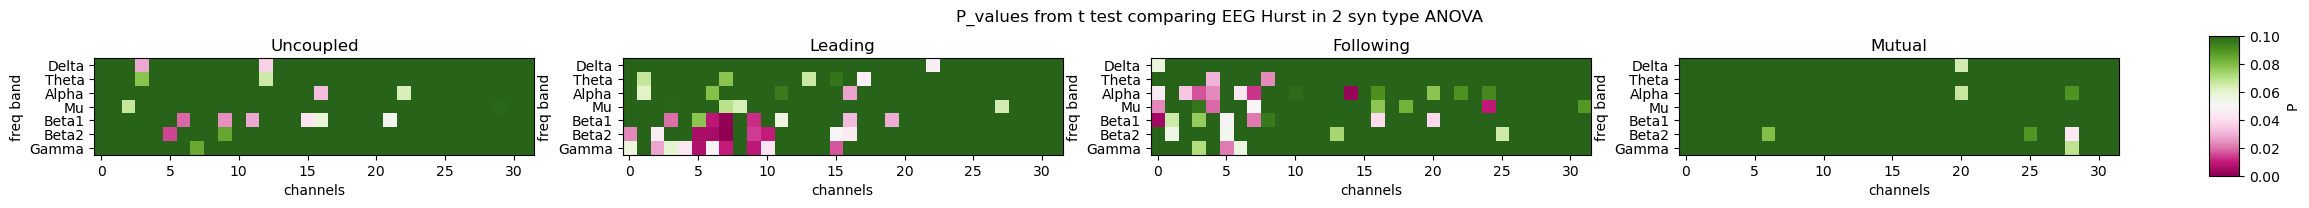

In [75]:
# plot the p values
fig, ax = plt.subplots(1,4,figsize=(30, 2))
for st in range(4):
    plt.sca(ax[st])
    compare1=plt.imshow(P_values[st,:,:],vmin=0,vmax=0.1,cmap=plt.cm.PiYG)
    plt.xlabel('channels'); plt.ylabel('freq band')
    plt.yticks(np.arange(7),band_labels,rotation=0)
    plt.title(states4names[st])
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.01, 0.7])
cbar_node=fig.colorbar(compare1,cbar_ax)
cbar_node.ax.tick_params(labelsize=10)
cbar_node.set_label('P')
plt.suptitle('P_values from t test comparing EEG Hurst in 2 syn type ANOVA')



In [64]:
# var=list()
# for st in range(4):
#     var.append(eeg_H_var[syn,st,:,freq,chan]) 

In [ ]:
# [eeg_H_var[syn,st,:,freq,chan] for st in range(4)]

In [76]:
# ANOVA
P_values=np.zeros((2,7,32))
for syn in range(2):
    for freq in range(7):
        for chan in range(32):
            statistic, P_values[syn,freq,chan] = f_oneway(eeg_H_var[syn,0,:,freq,chan],
                eeg_H_var[syn,1,:,freq,chan],eeg_H_var[syn,2,:,freq,chan],eeg_H_var[syn,3,:,freq,chan])



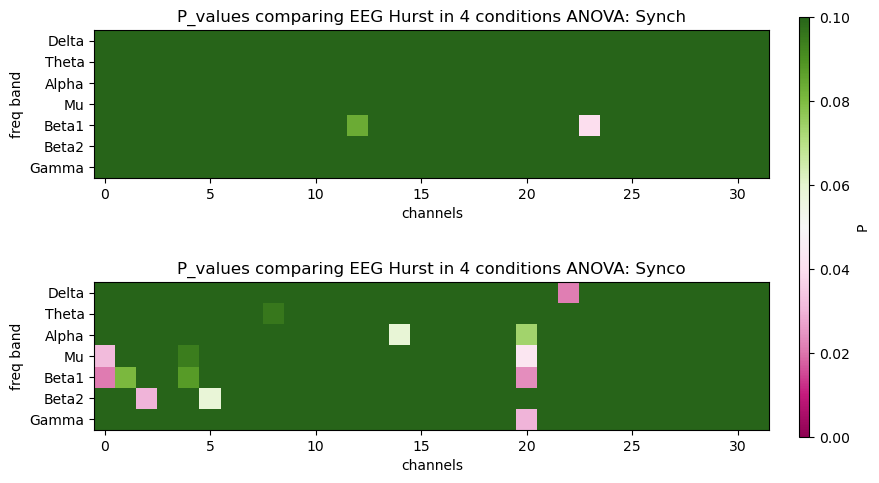

In [77]:
# plot the p values
fig, ax = plt.subplots(2,1,figsize=(10, 6))
for syn in range(2):
    plt.sca(ax[syn])
    compare1=plt.imshow(P_values[syn,:,:],vmin=0,vmax=0.1,cmap=plt.cm.PiYG)
    plt.xlabel('channels'); plt.ylabel('freq band')
    plt.yticks(np.arange(7),band_labels,rotation=0)
    plt.title('P_values comparing EEG Hurst in 4 conditions ANOVA: '+syn2names[syn])
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.01, 0.7])
cbar_node=fig.colorbar(compare1,cbar_ax)
cbar_node.ax.tick_params(labelsize=10)
cbar_node.set_label('P')

In [79]:
# load chan locs for topoplots
dict_loc=loadmat('../Pcorr_4states_2sestype/chan_locs/xyzlabels.mat')
x=dict_loc['x']
y=dict_loc['y']
z=dict_loc['z']
labels=dict_loc['labels']

# adjust coords for nilearn plots
coords=np.zeros((32,3))
for i in range(32):
    coords[i,:]=[x[i]*700, y[i]*900-15, z[i]*950-15]

#  construct text for networkx labels
labeldict = {}
for i in range(32):
    labeldict[i]=labels[i]

# load pos for networkx plots
pos_mat=loadmat('../Pcorr_4states_2sestype/chan_locs/pos.mat')
pos=pos_mat['pos']


# construct full edges_list
edges_list=list() # each edge is a two element tuple
for i in range(32):
    for j in range(32):
        if i<j: # use indicies to remove half of edges and colors and the diagonal
            edges_list.append((i,j))

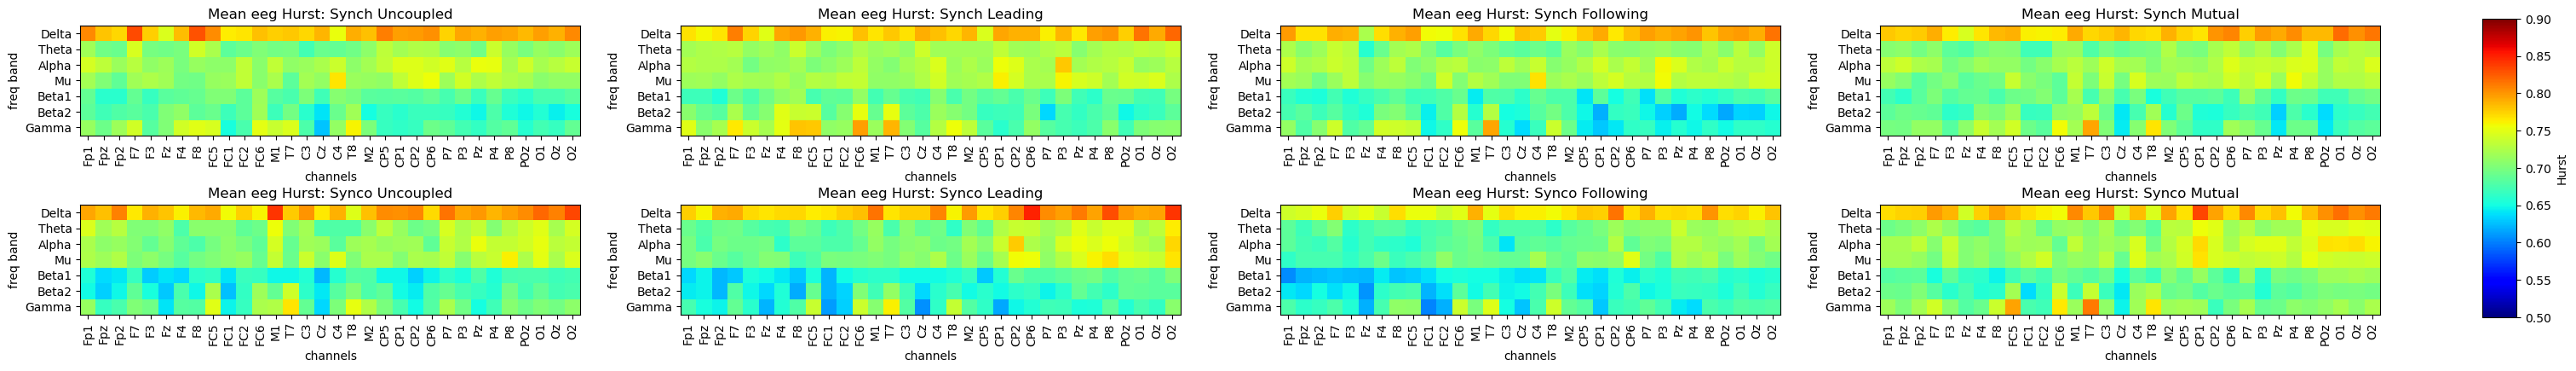

In [83]:
# plot 2 syn x 4 condi 
# (note "condition" of leading and following here is different from 
# "condition" of L-lead and R-lead in the experiment design)
fig, ax = plt.subplots(2,4,figsize=(10*4, 5))
for syn in range(2):
    for condi in range(4):
        plt.sca(ax[syn,condi])
        compare1=plt.imshow(eeg_H_mean[syn,condi,:,:],vmin=0.5,vmax=0.9,cmap=plt.cm.jet)
        plt.xlabel('channels'); plt.ylabel('freq band')
        plt.xticks(np.arange(32),labels,rotation=90)
        plt.yticks(np.arange(7),band_labels,rotation=0)
        plt.title('Mean eeg Hurst: '+syn2names[syn]+' '+states4names[condi])
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.01, 0.7])
cbar_node=fig.colorbar(compare1,cbar_ax)
cbar_node.ax.tick_params(labelsize=10)
cbar_node.set_label('Hurst')

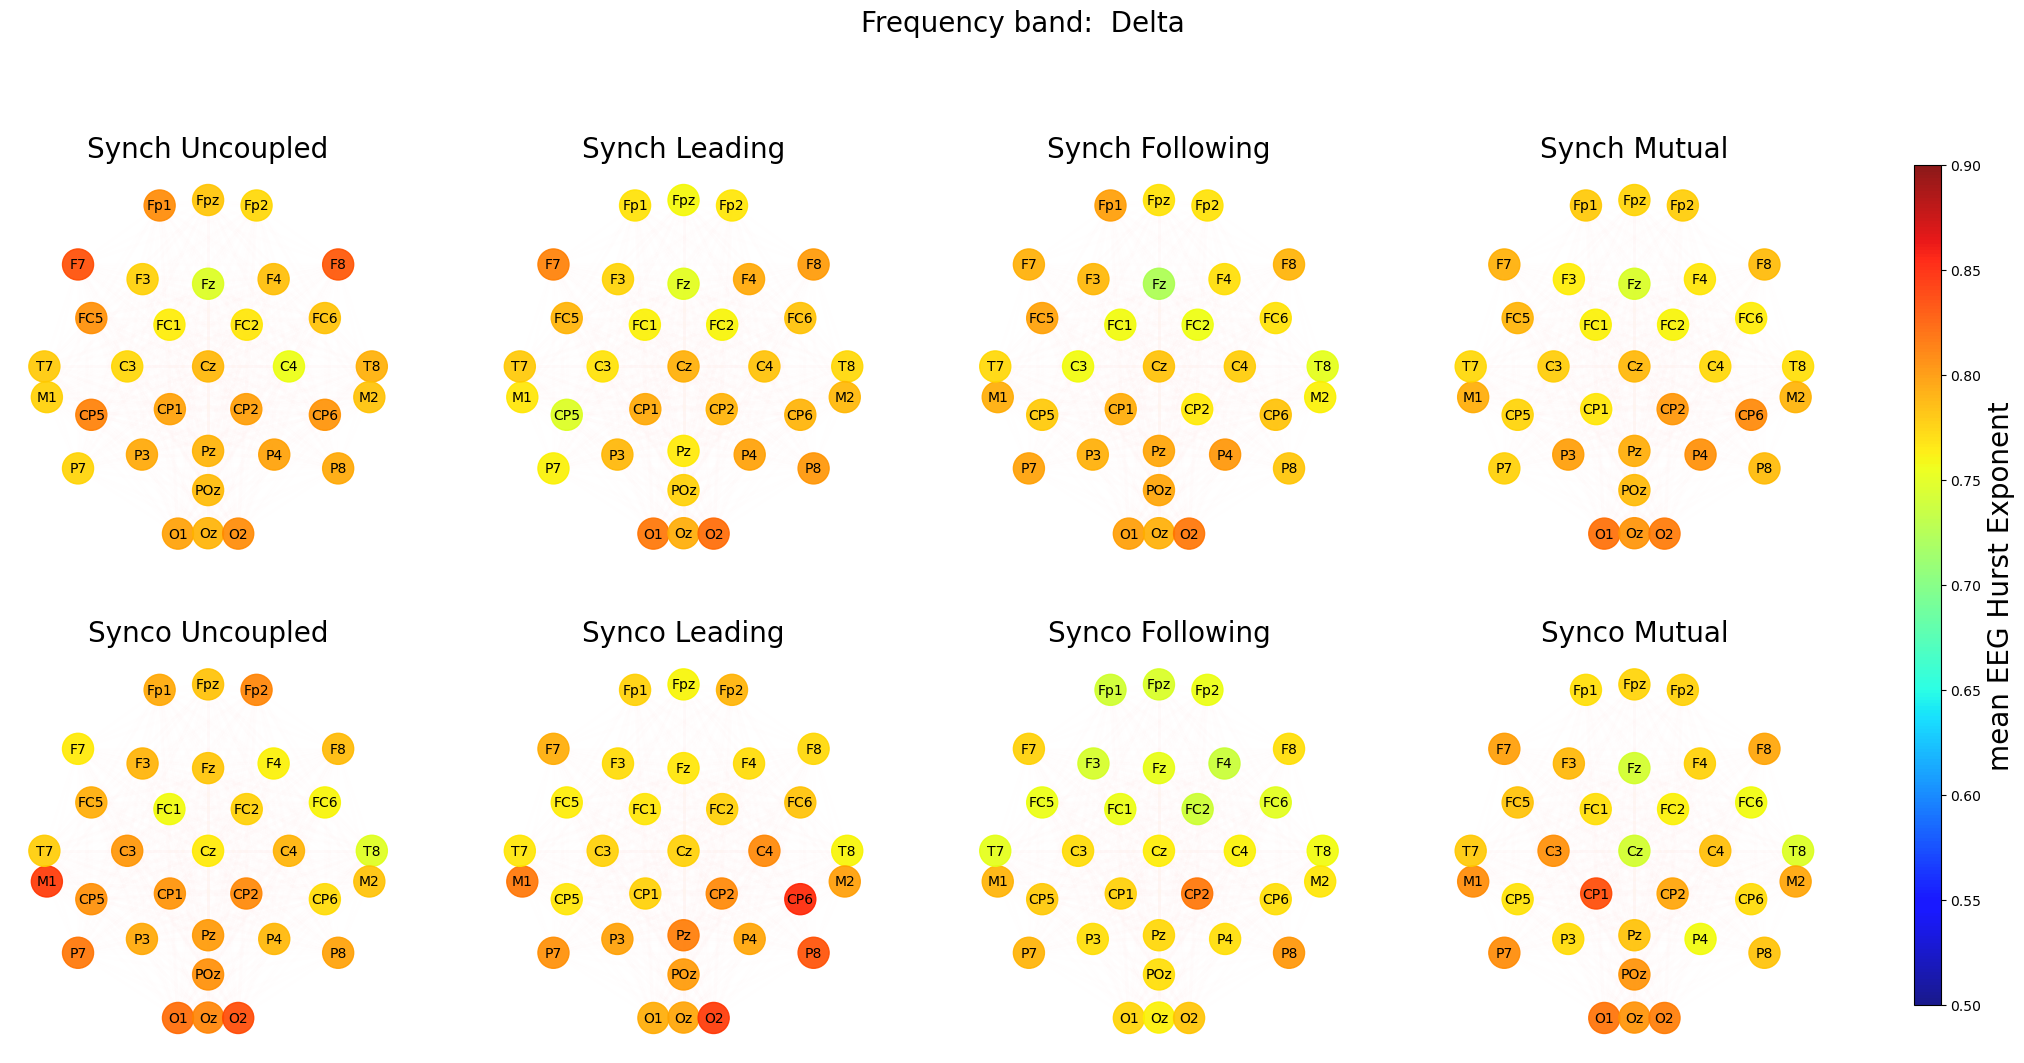

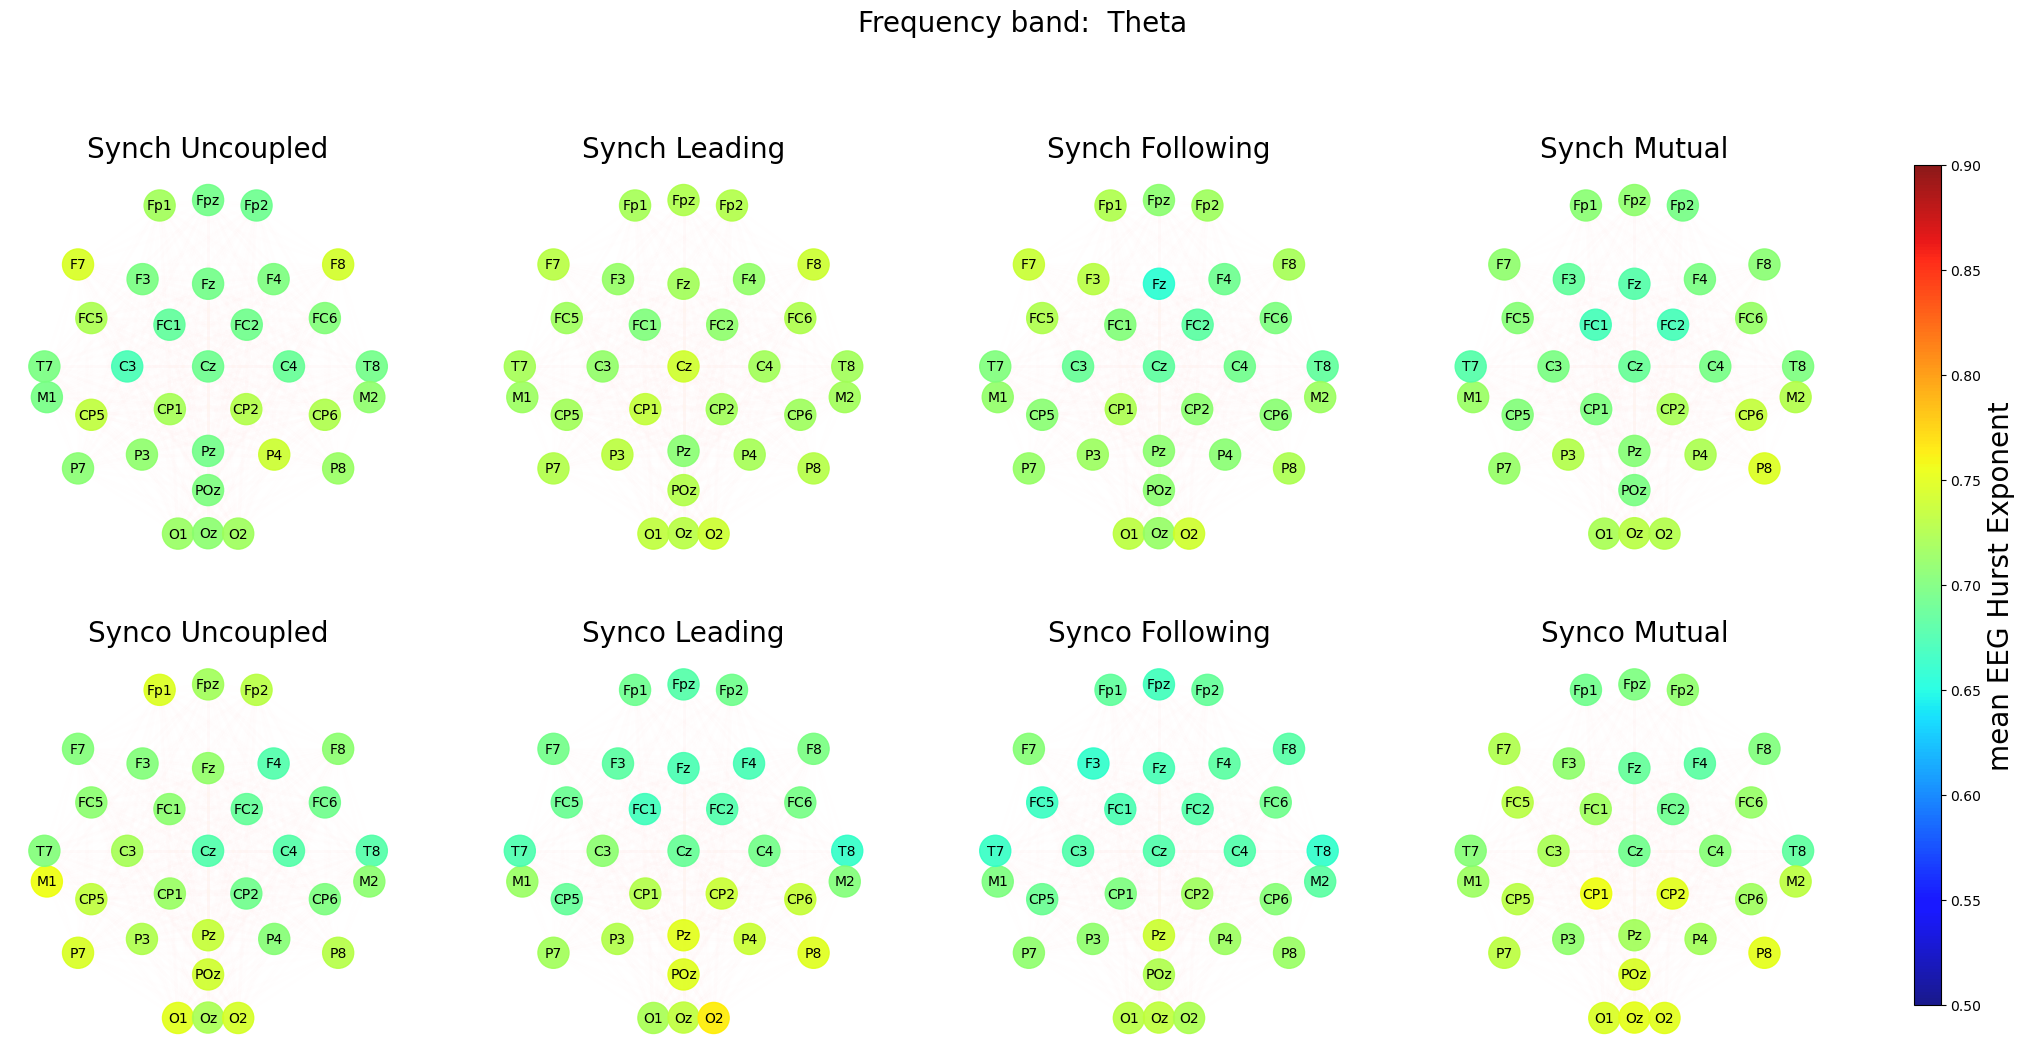

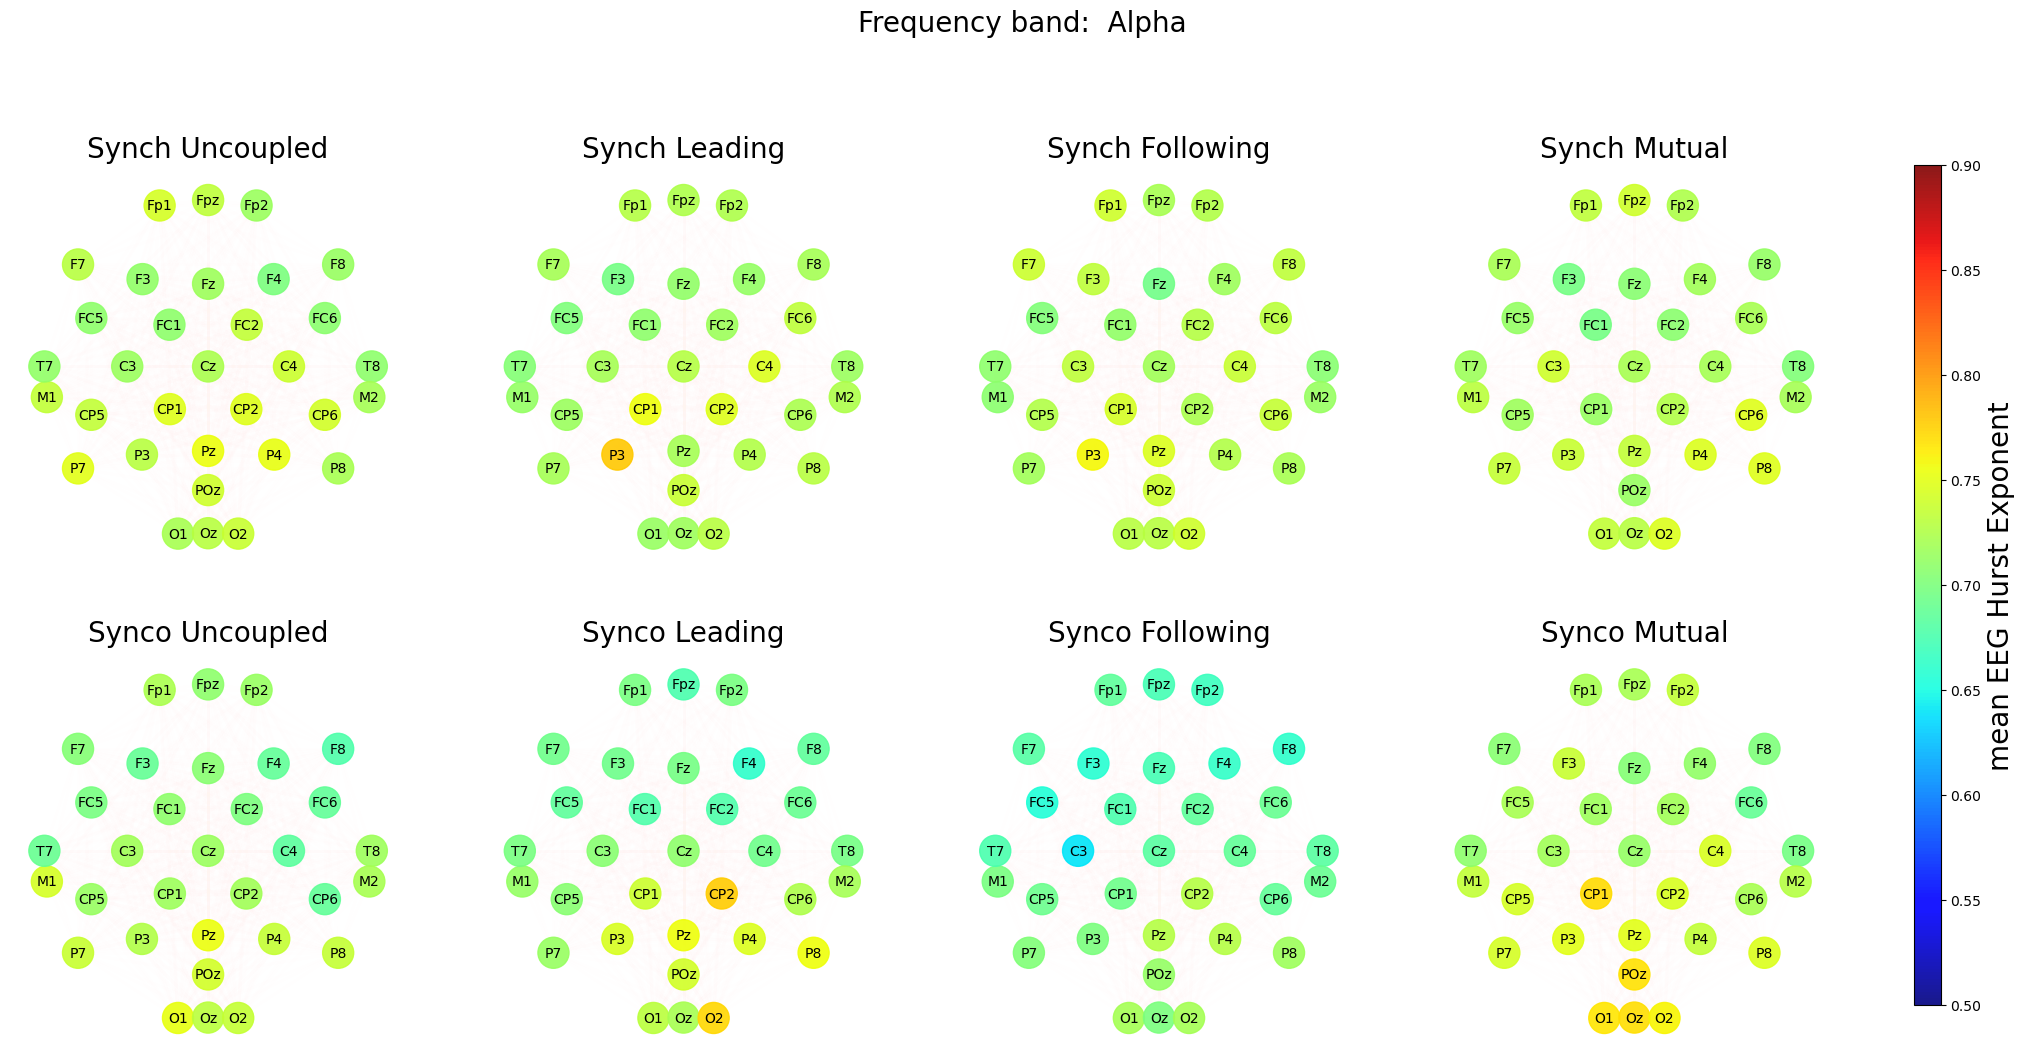

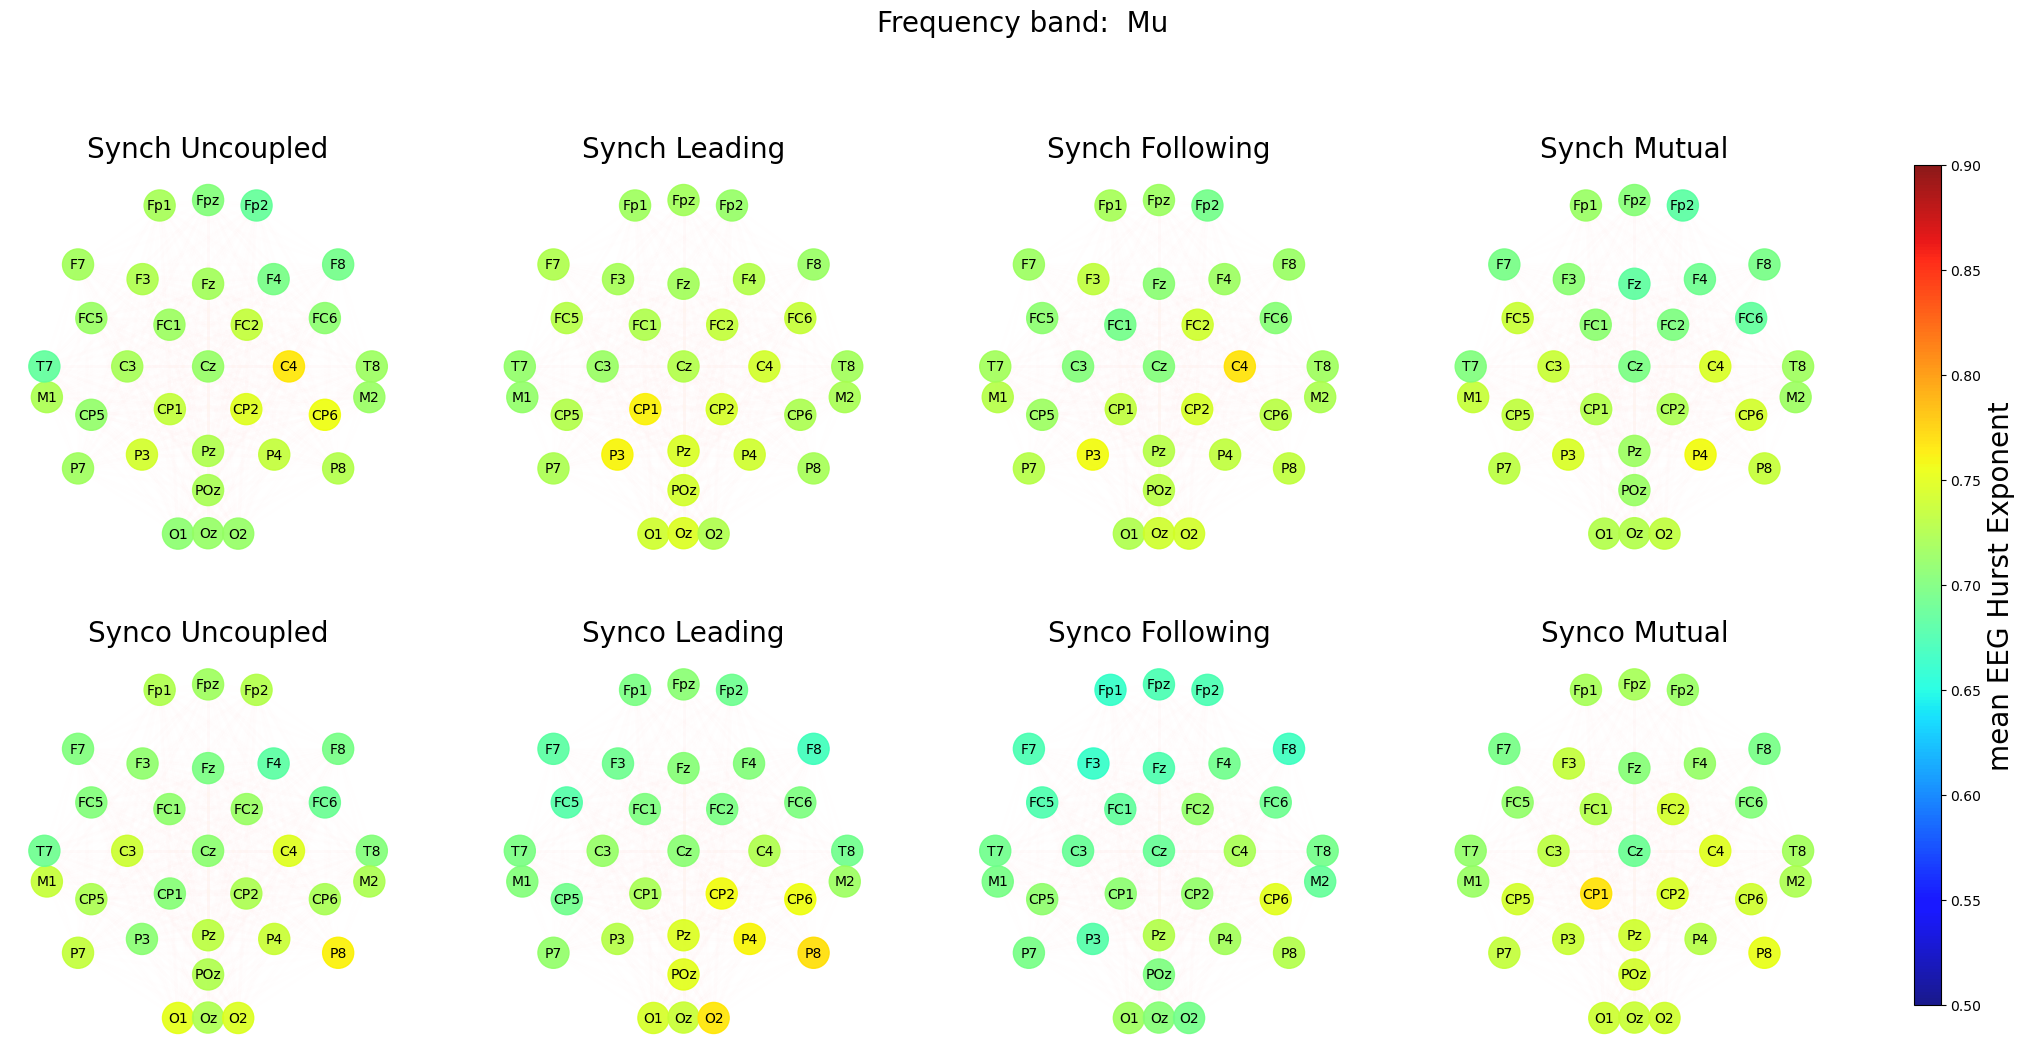

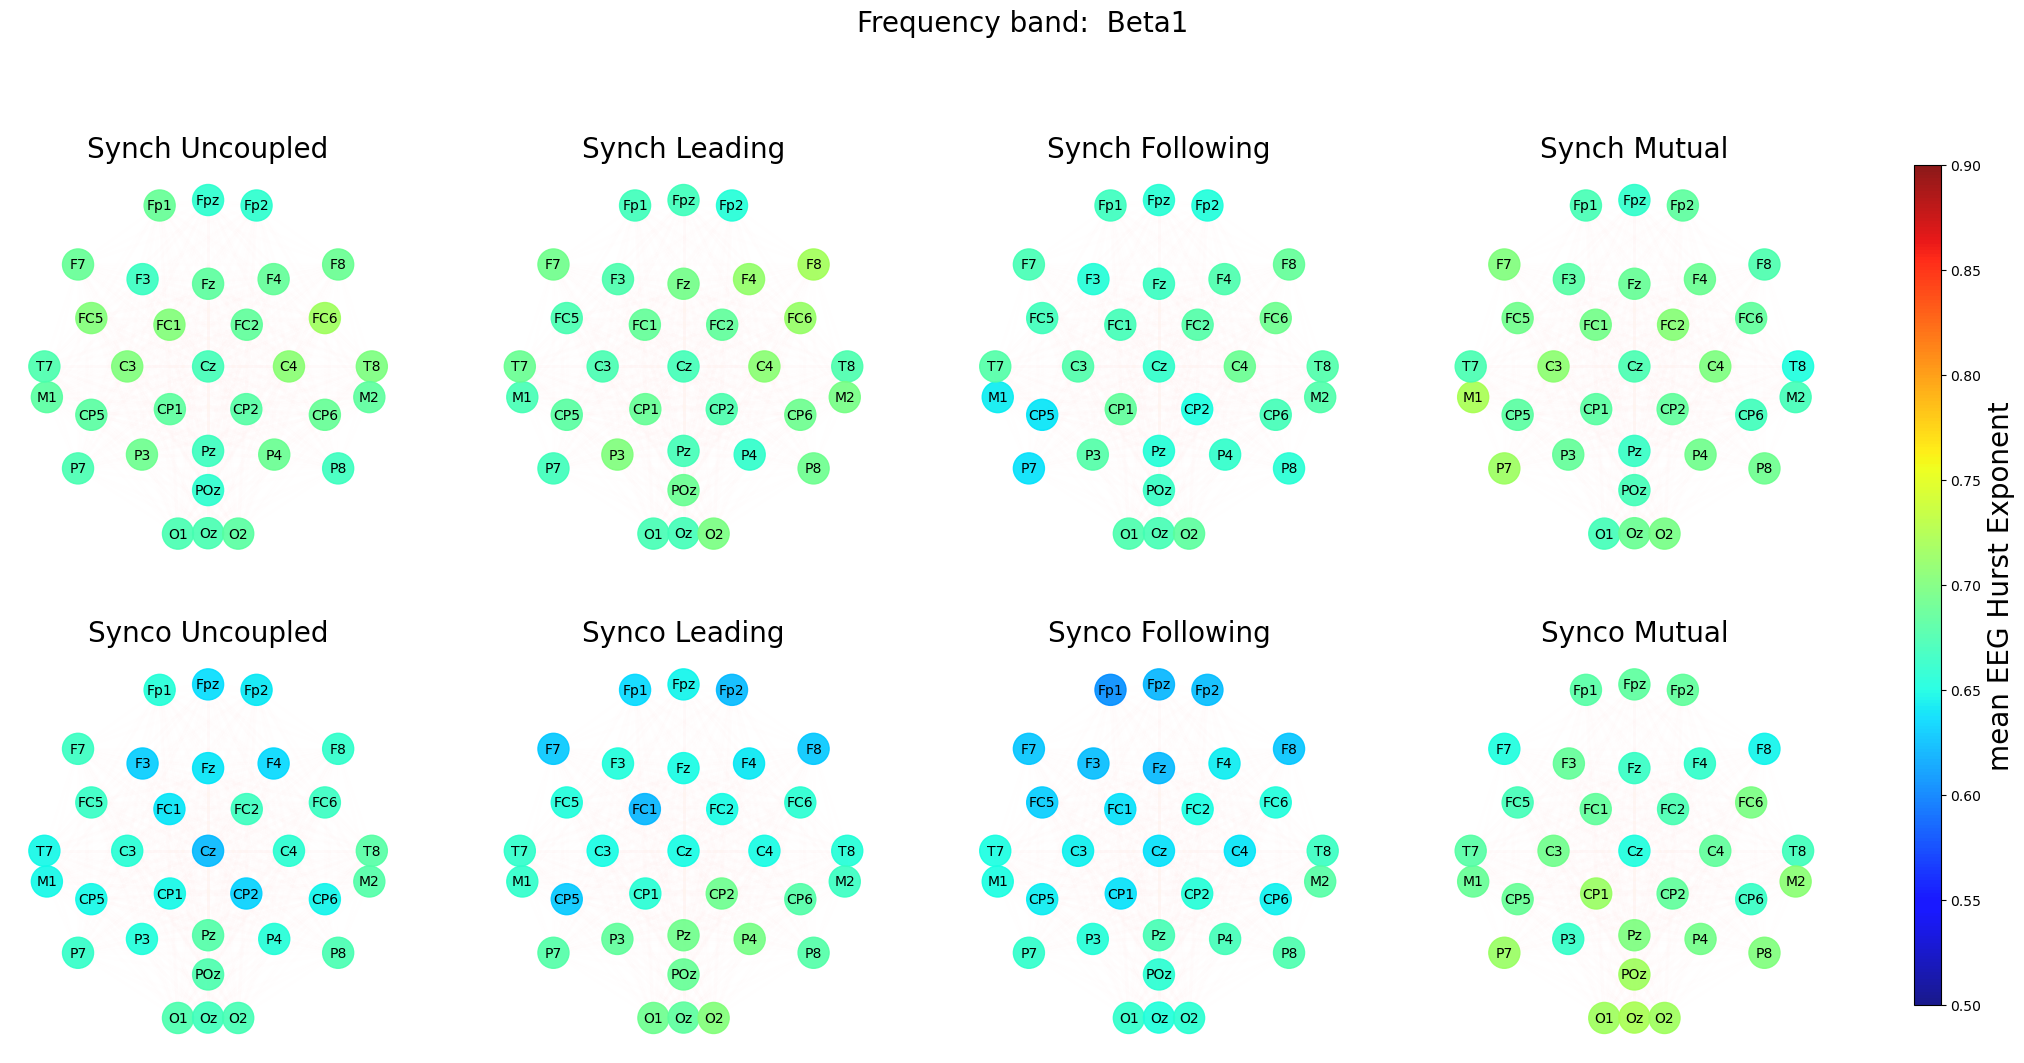

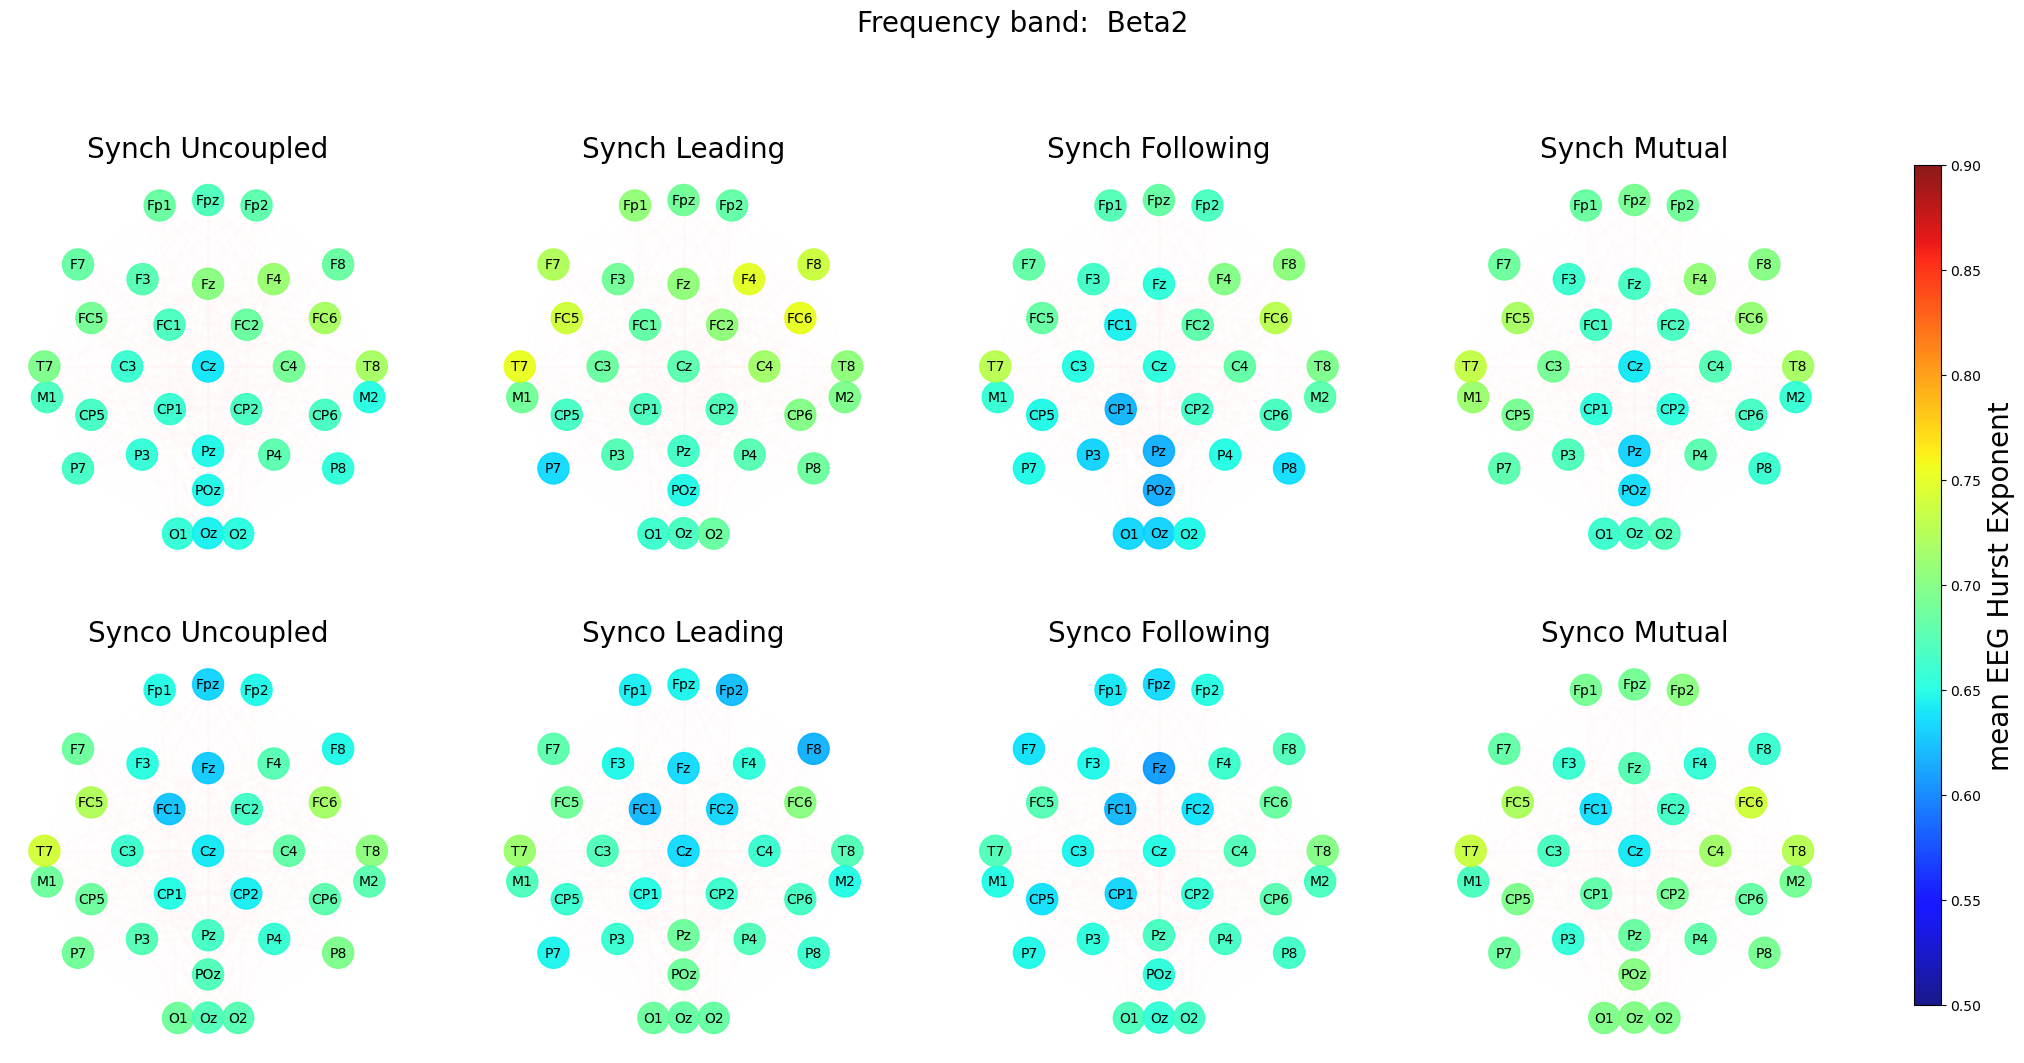

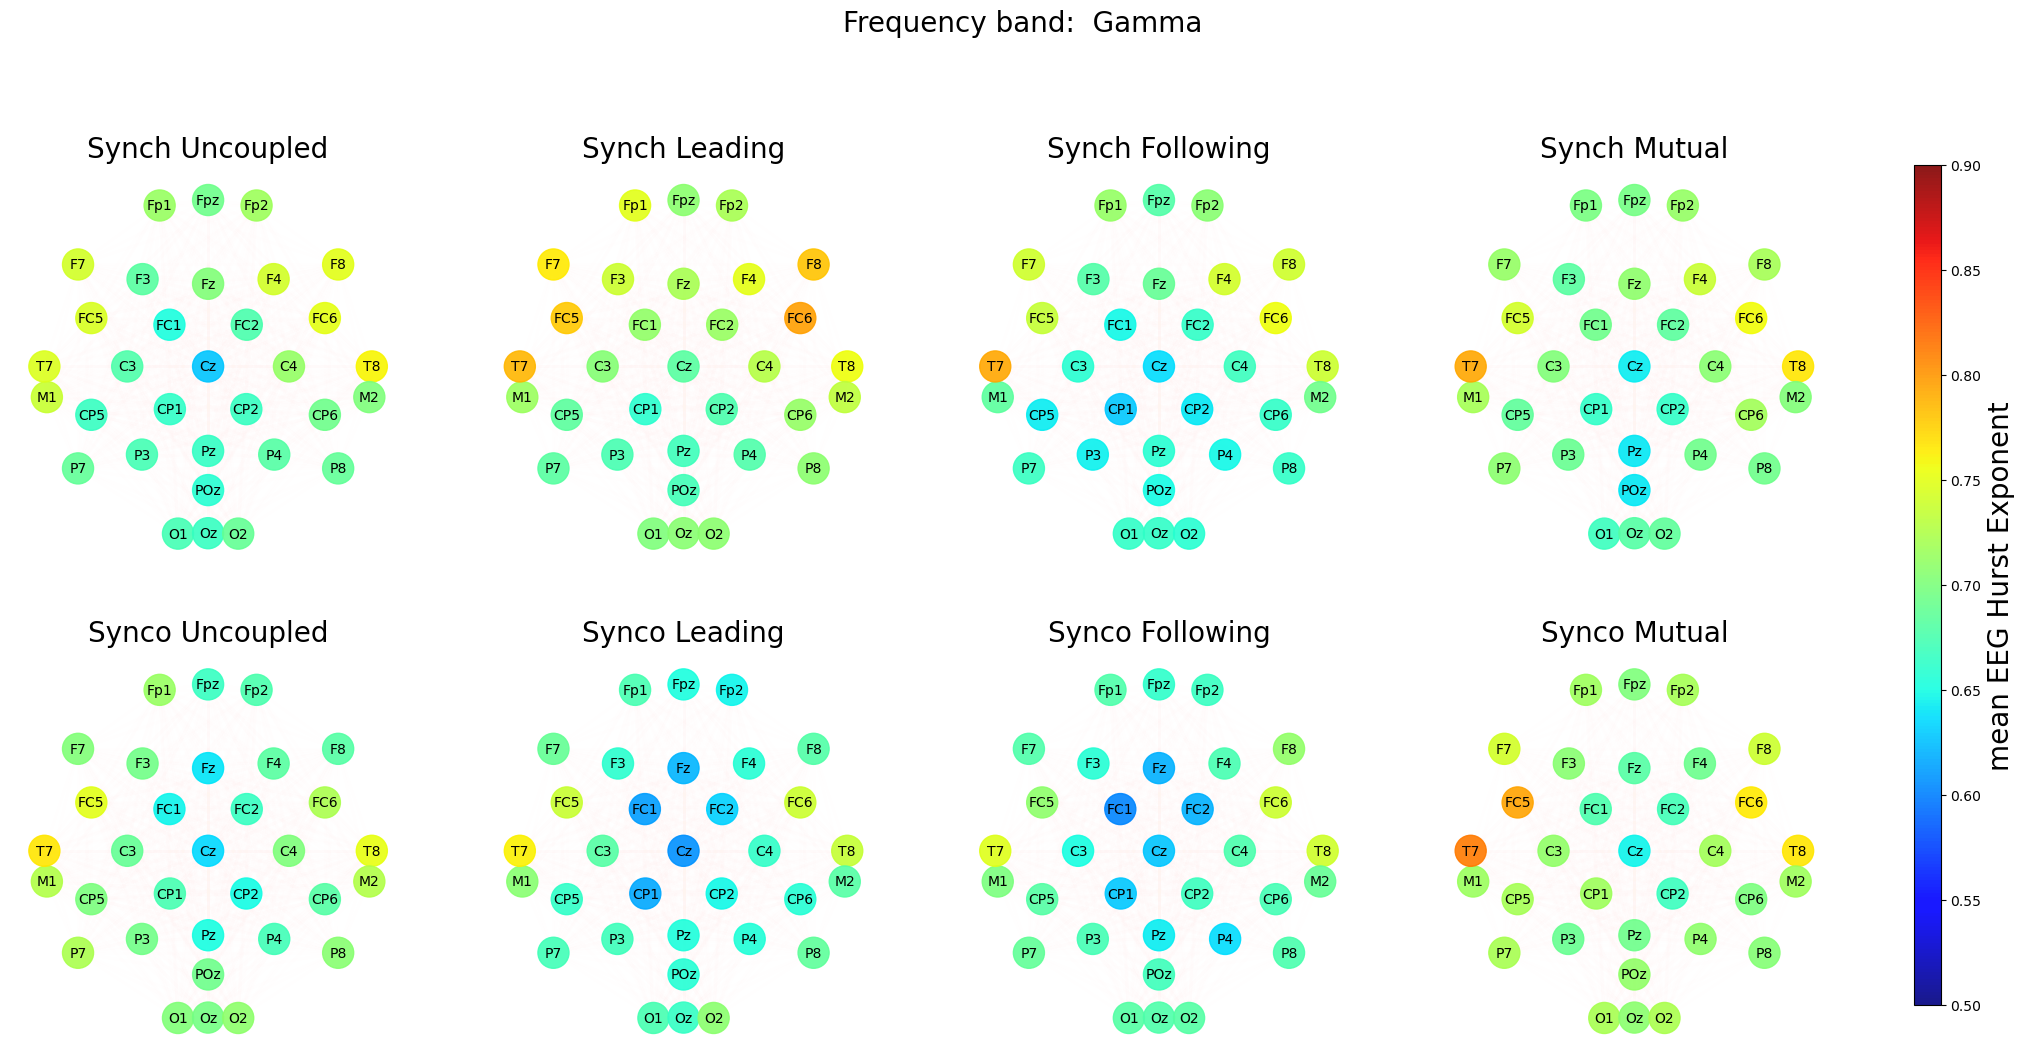

In [84]:
# Showing Hurst exponents
import networkx as nx
# select a freq band to investigate
for freq in range(7): # alpha and gamma
        fig, ax = plt.subplots(2,4,figsize=(6*4+3, 6*2))

        for syn in range(2):
                for condi in range(4):
                        non0_edges=list()
                        for i in range(len(edges_list)): # 496
                                non0_edges.append(edges_list[i]+({'weight': 0},))
                        # networkx initiate with edges
                        X = nx.Graph()
                        X.add_edges_from(non0_edges)
                        edges,non0_weights = zip(*nx.get_edge_attributes(X,'weight').items())

                        node_colors=eeg_H_mean[syn,condi,freq,:]

                        # set colorbar limits for node and edge from the 1st subplot
                        if syn==0 and condi ==0:
                                vmin_node_c=0.5 #min(node_colors)#+0.9*(max(node_colors)-min(node_colors))
                                vmax_node_c=0.9 # max(node_colors)#-0.45*(max(node_colors)-min(node_colors))
                                vmin_edge_c=0
                                vmax_edge_c=1
                        
                        # subplot
                        plt.sca(ax[syn, condi])

                        nx.draw_networkx_labels(X, pos, labels=labeldict, font_size=10)

                        nodes=nx.draw_networkx_nodes(X, pos, node_size=500, 
                                node_color=node_colors, vmin=vmin_node_c, vmax=vmax_node_c, 
                                cmap='jet', alpha=0.9)

                        edges=nx.draw_networkx_edges(X, pos, width=2, 
                                edge_color=non0_weights,edge_vmin=vmin_edge_c,edge_vmax=vmax_edge_c,
                                edge_cmap=plt.cm.Reds,alpha=0.01)
                        
                        ax[syn, condi].set_title(syn2names[syn] + ' ' + states4names[condi],
                                                fontsize = 20) 
                        ax[syn, condi].axis('off')


        fig.subplots_adjust(right=0.8)
        cbar_ax1 = fig.add_axes([0.83, 0.15, 0.01, 0.7])
        # cbar_ax2 = fig.add_axes([0.88, 0.15, 0.01, 0.7])

        cbar_node=fig.colorbar(nodes,cbar_ax1)
        cbar_node.ax.tick_params(labelsize=10)
        cbar_node.set_label('mean EEG Hurst Exponent',fontsize = 20)

        # cbar_edges=fig.colorbar(edges,cbar_ax2)
        # cbar_edges.ax.tick_params(labelsize=10)
        # cbar_edges.set_label('mean average pcorr re-estimated')

        fig.subplots_adjust(top=0.85)
        fig.suptitle('Frequency band:  '+band_labels[freq], fontsize = 20) 
